In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import gzip
import tensorflow as tf
import glob
import math
import skimage
import json
from matplotlib.patches import Rectangle

In [2]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

def get_grid_vals(env, n_samples):
    n_samples = 50
    obs_space = env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)
    xys = np.meshgrid(xs, ys)
    return np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2)), xys

def get_replay_pool(checkpoint, checkpoint_dir):
    from softlearning.replay_pools.utils import get_replay_pool_from_variant

    variant = checkpoint['variant']
    train_env = checkpoint['training_environment']
    replay_pool = get_replay_pool_from_variant(variant, train_env)

    replay_pool_path = os.path.join(checkpoint_dir, 'replay_pool.pkl')
    replay_pool.load_experience(replay_pool_path)
    return replay_pool

def plot_trajectories(checkpoint, checkpoint_dir, num_trajectories=10):
    replay_pool = get_replay_pool(checkpoint, checkpoint_dir)
    trajectories = replay_pool.last_n_batch(100 * num_trajectories)['observations']['state_observation'] \
                    .reshape(num_trajectories, 100, -1)
    for i in range(num_trajectories):
        plt.plot(trajectories[i,:,0], trajectories[i,:,1], color='w', linewidth=1)

## Specify the Experiment Directory

In [5]:
common_dir = '/Users/kevintli/rail/data/ray_results'
universe = 'gym'
domain = 'Point2D'
task = 'Maze-v0'

In [6]:
base_path = os.path.join(common_dir, universe, domain, task)
exps = sorted(list(glob.iglob(os.path.join(base_path, '*'))))
for i, exp in enumerate(exps):
    print(f'{i} \t {exp.replace(base_path, "")}')
    
exp_choice = int(input('\n Which experiment do you want to analyze? (ENTER A NUMBER) \t'))

exp_path = exps[exp_choice]
print('\n')
seeds = sorted(list(glob.iglob(os.path.join(exp_path, '*'))))
seeds = [seed for seed in seeds if os.path.isdir(seed)]
for i, seed in enumerate(seeds):
    print(f'{i} \t {seed.replace(exp_path, "")}')
    
# TODO: Extend to analyzing all seeds
seed_choice = int(input('\n Which seed do you want to analyze? (ENTER A NUMBER) \t'))

seed_path = seeds[seed_choice]

print('PATH:\n', seed_path)

0 	 /2020-05-27T16-46-37-ddl_maze
1 	 /2020-05-27T18-08-07-ddl_maze_count
2 	 /2020-05-28T15-34-01-dynamics_aware_vice

 Which experiment do you want to analyze? (ENTER A NUMBER) 	1


0 	 /id=b10d1e58-seed=5665_2020-05-27_18-08-08m_k02ani
1 	 /id=b10db96c-seed=2276_2020-05-27_18-08-083tnxtdfm
2 	 /id=b10e2a3c-seed=8785_2020-05-27_18-08-082a4988sb
3 	 /id=b10e9e4a-seed=9604_2020-05-27_18-08-086u1x903v
4 	 /id=b111f374-seed=8761_2020-05-27_18-08-088ahet3e6
5 	 /id=b11364c0-seed=6292_2020-05-27_18-08-08k1txd1bx
6 	 /id=b11aefec-seed=2893_2020-05-27_18-08-09_vlnjkb9
7 	 /id=b11b69c2-seed=2745_2020-05-27_18-08-09a2k9l1i5
8 	 /id=b1222924-seed=3131_2020-05-27_20-21-51vik2awem
9 	 /id=b122a0e8-seed=9098_2020-05-27_20-23-31loo8zrsu
10 	 /id=b12a836c-seed=511_2020-05-27_20-25-01b16f1kt4
11 	 /id=b12af266-seed=9778_2020-05-27_20-25-03upld8wzv
12 	 /id=b135346a-seed=3899_2020-05-27_20-43-39om47n0aq
13 	 /id=b139866e-seed=5587_2020-05-27_20-44-35__q3ymuj
14 	 /id=b13acb1e-seed=5625_2020-05-27_22-1

In [7]:
# Print hyperparameters

with open(os.path.join(seed_path, 'params.pkl'), 'rb') as f:
    params = pickle.load(f)

# print(json.dumps(params, indent=4))
hyperparams = {
    'use_count_reward': params['environment_params']['training']['kwargs'].get('use_count_reward', False),
    'discount': params['algorithm_params']['kwargs']['discount'],
    'ext_reward_coeff': params['algorithm_params']['kwargs']['ext_reward_coeff']
}
for name, value in hyperparams.items():
    print(f"{name}: {value}")

use_count_reward: True
discount: 0.99
ext_reward_coeff: 0.5


## Specify the Checkpoint

In [8]:
checkpoint_to_analyze = 200

In [9]:
checkpoint_dir = os.path.join(seed_path, f'checkpoint_{checkpoint_to_analyze}')
with open(os.path.join(checkpoint_dir, 'checkpoint.pkl'), 'rb') as f:
    checkpoint = pickle.load(f)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


/Users/kevintli/anaconda3/envs/softlearning/lib/python3.7/site-packages/tensorflow_core/python/keras/layers/core.py:895: UserWarning: softlearning.rnd.utils is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
W0529 19:03:53.431048 140736058082176 deprecation.py:506] From /Users/kevintli/anaconda3/envs/softlearning/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0529 19:03:53.432619 140736058082176 deprecation.py:506] From /Users/kevintli/anaconda3/envs/softlearning/lib/python3.7/site-packages/tensorflow_core/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:

## Load and Visualize Distance Function

In [10]:
checkpoint.keys()

dict_keys(['variant', 'training_environment', 'evaluation_environment', 'algorithm', 'policy_weights', 'rnd_networks', 'distance_estimator'])

In [11]:
# Load the distance function, goal, and environment, 
# then make distance predictions at points on a 50x50 grid
distance_fn = checkpoint['distance_estimator']
train_env = checkpoint['training_environment']
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

n_samples = 50
grid_vals, _ = get_grid_vals(train_env, n_samples)
goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
dists = distance_fn.predict([grid_vals, goal_vals])

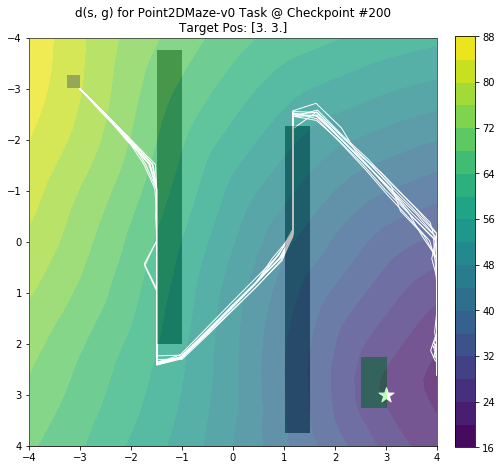

In [12]:
# Plot a contour map of distance predictions across the environment
plt.figure(figsize=(8, 8))
from matplotlib.patches import Rectangle

plt.imshow(train_env.render('rgb_array', width=32, height=32),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

grid_vals, xys = get_grid_vals(train_env, 50)
plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=20, zorder=1)
plt.colorbar(fraction=0.046, pad=0.04)

plot_trajectories(checkpoint, checkpoint_dir)

if task == 'BoxWall-v1':
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                          alpha=1, fill=None, linewidth=4))
    
plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

plt.title(f'd(s, g) for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

## Plot Evolution of Distance Function over Many Checkpoints

In [ ]:
def plot_distance_to_goal(distance_fn, train_env, n_samples=50):
    grid_vals, xys = get_grid_vals(train_env, n_samples)
    dists = distance_fn.predict([grid_vals, goal_vals])
    
#     plt.figure(figsize=(8, 8))
    from matplotlib.patches import Rectangle

    plt.imshow(train_env.render('rgb_array', width=32, height=32),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

    plt.gca().invert_yaxis()
    plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=20, zorder=1)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

In [ ]:
def plot_grid(imgs, labels=None):
    n_images = len(imgs)
    n_columns = np.sqrt(n_images)
    n_rows = np.ceil(n_images / n_columns) + 1
    plt.figure(figsize=(5 * n_columns, 5 * n_rows))
    for i, img in enumerate(imgs):
        plt.subplot(n_rows, n_columns, i+1)
        plt.axis('off')
        plt.imshow(img)
        if labels is not None:
            plt.title(labels[i], fontsize=20)
    plt.show()

In [ ]:
checkpoint_paths = list(glob.iglob(os.path.join(seed_path, 'checkpoint_*')))
# Sort by the checkpoint number at the end
checkpoint_paths = sorted(checkpoint_paths, key=lambda s: int(s.split("_")[-1]))

In [ ]:
n_plots = len(checkpoint_paths)
n_columns = int(np.sqrt(n_plots) + 1)
n_rows = np.ceil(n_plots / n_columns)
plt.figure(figsize=(5 * n_columns, 5 * n_rows))

imgs = []
for i, path in enumerate(checkpoint_paths):
    with open(os.path.join(path, 'checkpoint.pkl'), 'rb') as f:
        checkpoint = pickle.load(f)
    distance_fn = checkpoint['distance_estimator']
    train_env = checkpoint['training_environment']
    plt.subplot(n_rows, n_columns, i+1, aspect=1)
    plot_distance_to_goal(distance_fn, train_env)
    plt.title(int(path.split("_")[-1]), fontsize=20)
    
plt.show()

## Generate GIF of Distance over Time

In [ ]:
checkpoint_paths = list(glob.iglob(os.path.join(seed_path, 'checkpoint_*')))
# Sort by the checkpoint number at the end
checkpoint_paths = sorted(checkpoint_paths, key=lambda s: int(s.split("_")[-1]))

imgs = []
for i, path in enumerate(checkpoint_paths):
    fig = plt.figure(figsize=(8, 8))
    with open(os.path.join(path, 'checkpoint.pkl'), 'rb') as f:
        checkpoint = pickle.load(f)
    distance_fn = checkpoint['distance_estimator']
    train_env = checkpoint['training_environment']
    plot_distance_to_goal(distance_fn, train_env)
    plt.title(int(path.split("_")[-1]), fontsize=20)
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    imgs.append(data)

In [ ]:
import imageio
imageio.mimsave('./test.gif', imgs, duration=1.0)

## Plot Ground Truth Rewards

In [ ]:
feed_dict = {
    'state_achieved_goal': grid_vals,
    'state_desired_goal': np.full(grid_vals.shape, fill_value=2)
}
train_env.unwrapped.reward_type = 'sparse'
gtr = train_env.unwrapped.compute_rewards(None, feed_dict)
plt.figure(figsize=(8, 8))

from matplotlib.patches import Rectangle

plt.gca().invert_yaxis()

plt.contourf(xys[0], xys[1], gtr.reshape(xys[0].shape))
plt.colorbar(fraction=0.046, pad=0.04)

plt.scatter([2], [2], color='r')

if task == 'BoxWall-v1':
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                          alpha=1, fill=None, linewidth=4))

plt.title(f'Ground Truth Reward for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}')

plt.scatter(*target_pos, marker='*', s=250, color='white')
plt.show()

## Qs Visualization

In [ ]:
# Load the checkpoint
checkpoint_to_analyze = 200
checkpoint_dir = os.path.join(seed_path, f'checkpoint_{checkpoint_to_analyze}')

with open(os.path.join(checkpoint_dir, 'checkpoint.pkl'), 'rb') as f:
    checkpoint = pickle.load(f)

In [ ]:
variant = checkpoint['variant']
env = checkpoint['training_environment']
target_pos = env.unwrapped._get_obs()['state_desired_goal']

In [ ]:
from softlearning.value_functions.utils import get_Q_function_from_variant

In [ ]:
# Initialize a double value function and load weights from the checkpoint file
Qs = get_Q_function_from_variant(variant, env)

for i, Q in enumerate(Qs):
    weights_path = os.path.join(checkpoint_dir, f'Qs_{i}')
    Q.load_weights(weights_path)

In [ ]:
# Sample n actions from the full action space.
# We will plot the worst-case Q value over all of these actions (?)
n_action_samples = 20
sample_actions = np.vstack([env.action_space.sample() for _ in range(n_action_samples)])

In [ ]:
# Create a 50x50 grid of coordinates to evaluate
n_samples = 50
grid_vals, xys = get_grid_vals(env, n_samples)

In [ ]:
# Compute Q values at each coordinate
value_estimates = []
for pos in grid_vals:
    value_estimates.append(
        np.min([Q.predict([sample_actions,
                        np.repeat(pos, n_action_samples).reshape((n_action_samples, -1))])
             for Q in Qs])
    )

In [ ]:
# Plot a contour map of value estimates
plt.figure(figsize=(8, 8))
from matplotlib.patches import Rectangle

plt.imshow(train_env.render('rgb_array', width=32, height=32),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)
plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], np.array(value_estimates).reshape(xys[0].shape))
plt.colorbar(fraction=0.046, pad=0.04)

if task == 'BoxWall-v1':
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-2, -2), 4, 4,
                          alpha=1, fill=None, linewidth=4))
    
plot_trajectories(checkpoint, checkpoint_dir)

plt.scatter(*target_pos, marker='*', s=250, color='white')
plt.title(f'Value function estimates for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

In [ ]:
np.repeat(grid_vals[0], n_action_samples).reshape((n_action_samples, -1))

## Visualize Embedding Function

In [13]:
embedding_fn = checkpoint['distance_estimator']
train_env = checkpoint['training_environment']
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

n_samples = 50
grid_vals = get_grid_vals(train_env, n_samples)
goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
dists = np.linalg.norm(embedding_fn.predict(goal_vals) - embedding_fn.predict(grid_vals), axis=-1)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[3., 3.],
       [3., 3.],
       [3., 3.],
       ...,
       [3., 3.],
       [3., 3.],
       [3., 3.]])]...

In [ ]:
plt.figure(figsize=(8, 8))
from matplotlib.patches import Rectangle

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

plt.gca().invert_yaxis()
plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=300, zorder=1)
plt.colorbar(fraction=0.046, pad=0.04)
    
plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

plt.title(f'|phi(g) - phi(s)| for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

In [ ]:
embedded_goal = embedding_fn.predict(target_pos[None])

In [ ]:
radii = np.arange(0.5, 9, 0.5)
pts_by_radius = []
for r in radii:
    embedded_pts = []
    for theta in np.arange(0, 2 * np.pi + np.pi / 30, np.pi / 30):
        dx = r * np.cos(theta)
        dy = r * np.sin(theta)
        pt = target_pos + np.array([dx, dy])
        x, y = pt
        if -4 <= x and x <= 4 and -4 <= y and y <= 4:
            embedded_pt = embedding_fn.predict(pt[None])
            embedded_pts.append(embedded_pt)
    pts_by_radius.append(np.vstack(embedded_pts))

In [ ]:
border_pts = []
border_range = np.arange(-4 + 0.1, 4 - 0.1, 0.1).reshape(-1, 1)
border_pts.append(np.hstack(
    (np.ones(border_range.shape) * (4 - 0.1), border_range)
))
border_pts.append(np.hstack(
    (np.ones(border_range.shape) * (-4 + 0.1), border_range)
))
border_pts.append(np.hstack(
    (border_range, np.ones(border_range.shape) * (-4 + 0.1))
))
border_pts.append(np.hstack(
    (border_range, np.ones(border_range.shape) * (4 - 0.1))
))
border_pts = np.vstack(border_pts)

In [ ]:
embedded_border = embedding_fn.predict(border_pts)

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(embedded_goal[0][0], embedded_goal[0][1])
for pts in pts_by_radius:
    plt.plot(pts[:, 0], pts[:, 1])
plt.legend(radii)
plt.title('Trajectory in Embedding Space')

plt.plot(embedded_trajectory[:, 0], embedded_trajectory[:, 1], 'black')
# plt.quiver(embedded_trajectory[:-1, 0],
#            embedded_trajectory[:-1, 1],
#            embedded_actions[:, 0],
#            embedded_actions[:, 1],
#            color='black',
#            alpha=0.5,
#            linewidth=2,
#            headwidth=4)

In [ ]:
plt.figure(figsize=(8, 8))

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)
plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

trajectory = sample_trajectory['observations']['state_observation']
next_obs = sample_trajectory['next_observations']['state_observation']
actions = next_obs - trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], 'black')

radii = np.arange(0.5, 9, 0.5)
circles = []
for r in radii:
    pts = []
    for theta in np.arange(0, 2 * np.pi + np.pi / 30, np.pi / 30):
        dx = r * np.cos(theta)
        dy = r * np.sin(theta)
        pt = target_pos + np.array([dx, dy])
        x, y = pt
        if -4 <= x and x <= 4 and -4 <= y and y <= 4:
            pts.append(np.array([[x, y]]))
    circles.append(np.vstack(pts))

for circle in circles:
    plt.plot(circle[:, 0], circle[:, 1])
    
plt.gca().invert_yaxis()

plt.title(f'|phi(g) - phi(s)| for {domain + task} Task @ Checkpoint #{checkpoint_to_analyze}\n'
          + f'Target Pos: {target_pos}')
plt.show()

In [ ]:
checkpoint.keys()

In [ ]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

variant = checkpoint['variant']
train_env = checkpoint['training_environment']
replay_pool = get_replay_pool_from_variant(variant, train_env)

replay_pool_path = os.path.join(checkpoint_dir, 'replay_pool.pkl')
replay_pool.load_experience(replay_pool_path)

In [ ]:
sample_trajectory = replay_pool.last_n_batch(100)

In [ ]:
embedded_trajectory = embedding_fn.predict(sample_trajectory['observations']['state_observation'])
embedded_actions = embedded_trajectory[1:, :] - embedded_trajectory[:-1, :]